In [29]:

!pip install oauthlib
!pip install requests_oauthlib
!pip install sentinelhub


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import pandas as pd
from PIL import Image
from datetime import datetime, timedelta
import requests
from data_mining.utils import plot_image

In [ ]:
# read fire history

In [ ]:
fire_data = pd.read_csv("data_mining/fire_data.csv")
fire_data = fire_data[["latitude", "longitude", "acq_date", "daynight"]]
print(fire_data)

In [3]:

# # Your client credentials
# client_id = '4d093505-d867-4ae4-90b0-468eb78dd9af'
# client_secret = 'UHSroMy3xUHqh0SakSXrPvCejglb2eyH'
# 
# # Create a session
# client = BackendApplicationClient(client_id=client_id)
# oauth = OAuth2Session(client=client)
# # Get token for the session
# token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
#                           client_secret=client_secret, include_client_id=True)
# 
# # All requests using this session will have an access token automatically added
# resp = oauth.get("https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances")
# 
# def sentinelhub_compliance_hook(response):
#     response.raise_for_status()
#     return response
# 
# oauth.register_compliance_hook("access_token_response", sentinelhub_compliance_hook)
# data = {
#     "bbox": [17.995, 40.488, 17.262, 40.574],
#     "datetime": "2024-04-07T00:00:00Z/2024-05-07T23:59:59Z",
#     "collections": ["sentinel-1-grd", 'sentinel-2-l1c'],
#     "limit": 5,
# }
# 
# url = "https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/search"
# response = oauth.post(url, json=data)
# response.json()

In [4]:
# Your client credentials
client_id = '4d093505-d867-4ae4-90b0-468eb78dd9af'
client_secret = 'UHSroMy3xUHqh0SakSXrPvCejglb2eyH'

url = 'https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token'
headers = {'content-type': 'application/x-www-form-urlencoded'}
data = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret
}
response = requests.post(url, headers=headers, data=data)
access_token=response.json()['access_token']

In [29]:
from sentinelhub import SHConfig, MimeType, CRS, BBox, SentinelHubRequest, DataCollection, bbox_to_dimensions

config = SHConfig()
config.instance_id = '880e1fdd-9935-4a80-b200-0c1468b320a8' 
config.sh_client_secret = client_secret
config.sh_client_id = client_id

In [30]:
from sentinelhub import MosaickingOrder


def get_sentinel_image(coordinates, time_interval, config):
    padding = 0.2
    bbox_coords_wgs = [coordinates[0] - padding, coordinates[1] - padding, coordinates[0] + padding, coordinates[1] + padding]
    bbox = BBox(bbox_coords_wgs, crs=CRS.WGS84)
    
    x_size = 190
    _, y_size = bbox_to_dimensions(bbox, resolution=x_size)
    # bands 8-12 are infrared bands
    eval_script = """
                //VERSION=3
                    function setup() {
                        return {
                            input: [{
                                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                                units: "DN"
                            }],
                            output: {
                                bands: 13,
                                sampleType: "INT16"
                            }
                        };
                    }
                    function evaluatePixel(sample) {
                        return [sample.B01,
                                sample.B02,
                                sample.B03,
                                sample.B04,
                                sample.B05,
                                sample.B06,
                                sample.B07,
                                sample.B08,
                                sample.B8A,
                                sample.B09,
                                sample.B10,
                                sample.B11,
                                sample.B12];
                    }
                """
    input_data = SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=(f'{time_interval[0]}T00:00:00Z', f'{time_interval[1]}T23:59:59Z'),
                mosaicking_order=MosaickingOrder.LEAST_CC
                )
    # print(eval_script)
    # print(input_data)
    # print(SentinelHubRequest.output_response('default', MimeType.TIFF))
    # print(config)
    request = SentinelHubRequest(
        evalscript=eval_script,
        input_data=[input_data],
        responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
        bbox=bbox,
        size=(x_size, y_size),  # Pass height as a single integer
        config=config
        )
    print(request.body(bbox,input_data, eval_script))
    image = request.get_data()[0]
    return image

In [23]:
import requests

def get_sentinel_image_requests(coordinates, time_interval, access_token):
    padding = 0.2
    bbox_coords_wgs = [coordinates[0] - padding, coordinates[1] - padding, coordinates[0] + padding, coordinates[1] + padding]
    
    # The URL to make the request to
    url = 'https://services.sentinel-hub.com/api/v1/process'

    # The headers for the request
    headers = {
        'Authorization': f'Bearer {access_token}',
        'Content-Type': 'application/json'
    }

    # The JSON payload for the request
    payload = {
        "input": {
            "bounds": {
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
                },
                "bbox": bbox_coords_wgs
            },
            "data": [
                {
                    "type": "sentinel-2-l1c",
                    "dataFilter": {
                        "timeRange": {
                            "from": f'{time_interval[0]}T00:00:00Z',
                            "to": f'{time_interval[1]}T23:59:59Z'
                        }
                    }
                }
            ]
        },
        "output": {
            "width": 512,
            "height": 512,
            "responses": [
                {
                    "identifier": "default",
                    "format": {
                        "type": "image/tiff"
                    }
                }
            ]
        },
        "evalscript": """
        //VERSION=3
            function setup() {
                return {
                    input: [{
                        bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                        units: "DN"
                    }],
                    output: {
                        bands: 13,
                        sampleType: "INT16"
                    }
                };
            }
            function evaluatePixel(sample) {
                return [sample.B01,
                        sample.B02,
                        sample.B03,
                        sample.B04,
                        sample.B05,
                        sample.B06,
                        sample.B07,
                        sample.B08,
                        sample.B8A,
                        sample.B09,
                        sample.B10,
                        sample.B11,
                        sample.B12];
            }
        """
    }

    # Make the POST request
    response = requests.post(url, headers=headers, json=payload)
    # this is an TIFF image 
    return response.content

{'input': {'bounds': BBox(((17.01493, 40.301959999999994), (17.41493, 40.70196)), crs=CRS('4326')), 'data': InputDataDict({'type': 'sentinel-2-l1c', 'dataFilter': {'timeRange': {'from': '2024-05-06T00:00:00Z', 'to': '2024-05-07T23:59:59Z'}, 'mosaickingOrder': 'leastCC'}}, service_url=https://services.sentinel-hub.com)}, 'evalscript': '\n                //VERSION=3\n                    function setup() {\n                        return {\n                            input: [{\n                                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],\n                                units: "DN"\n                            }],\n                            output: {\n                                bands: 13,\n                                sampleType: "INT16"\n                            }\n                        };\n                    }\n                    function evaluatePixel(sample) {\n                        return [sample.B01,\n   

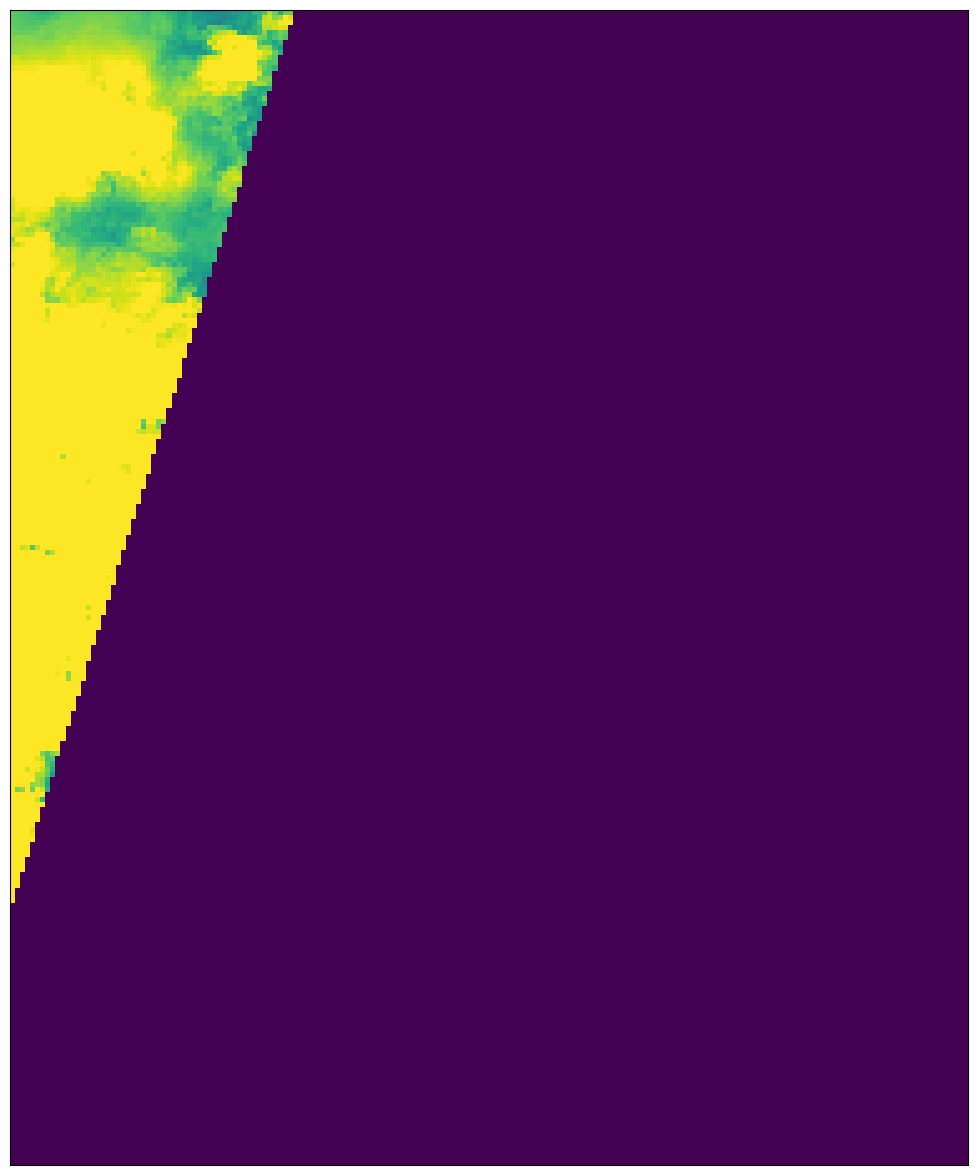

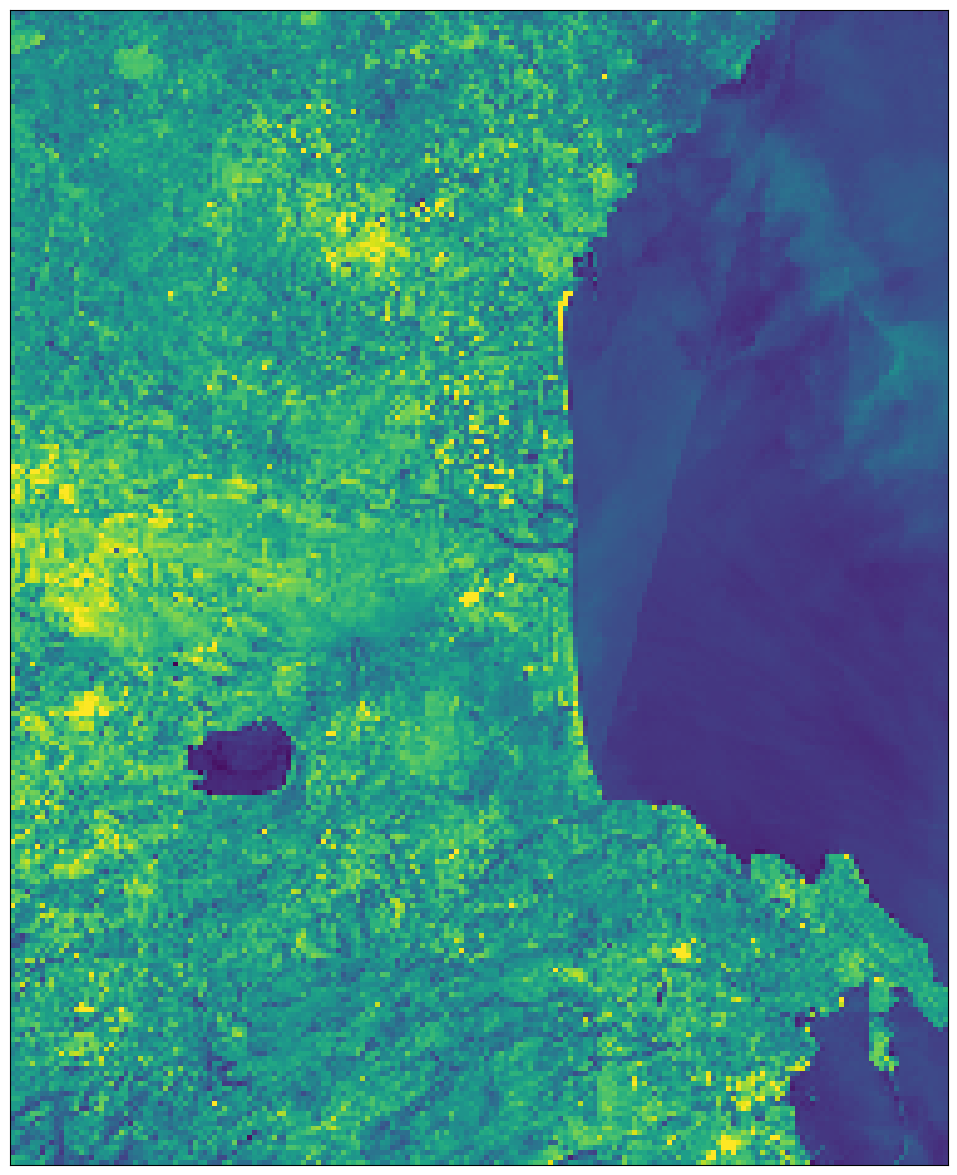

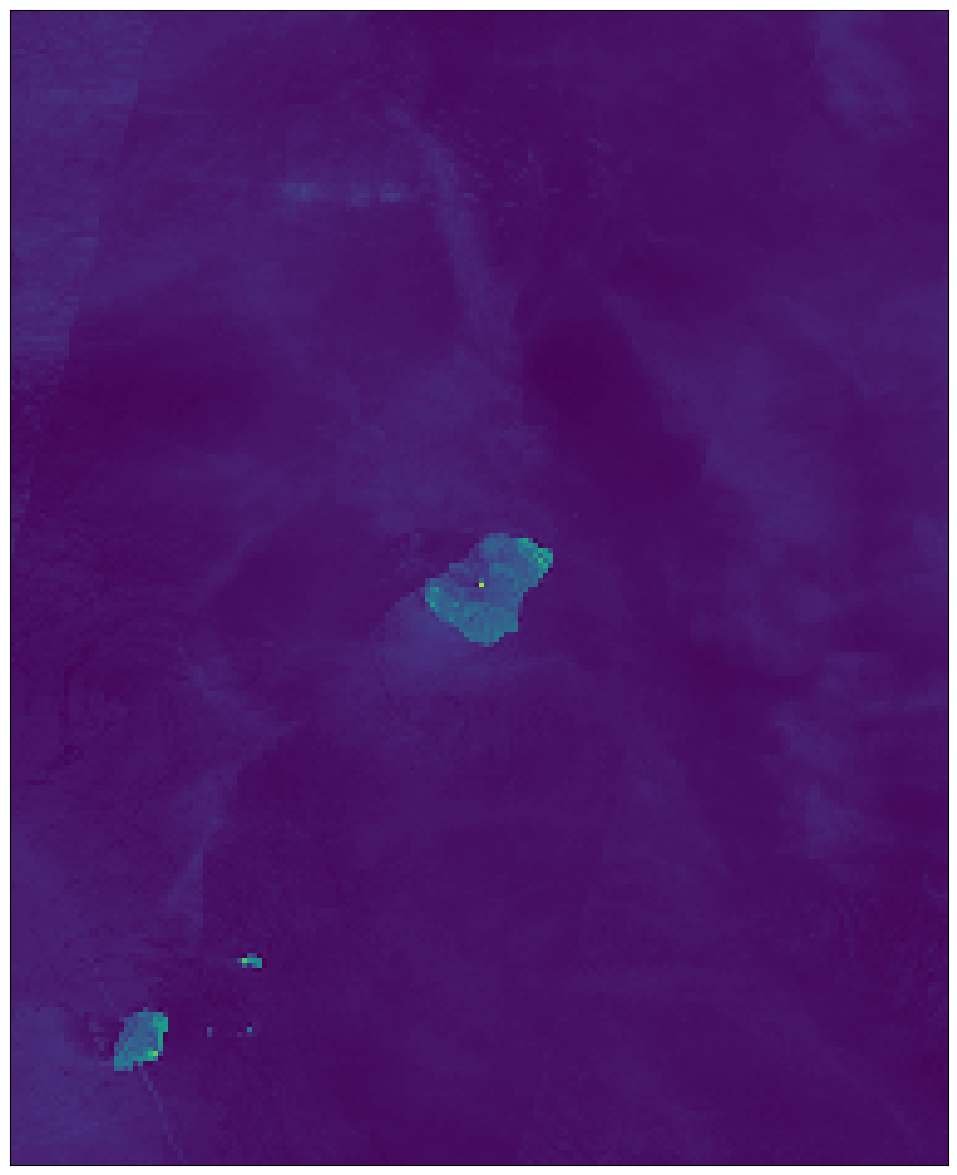

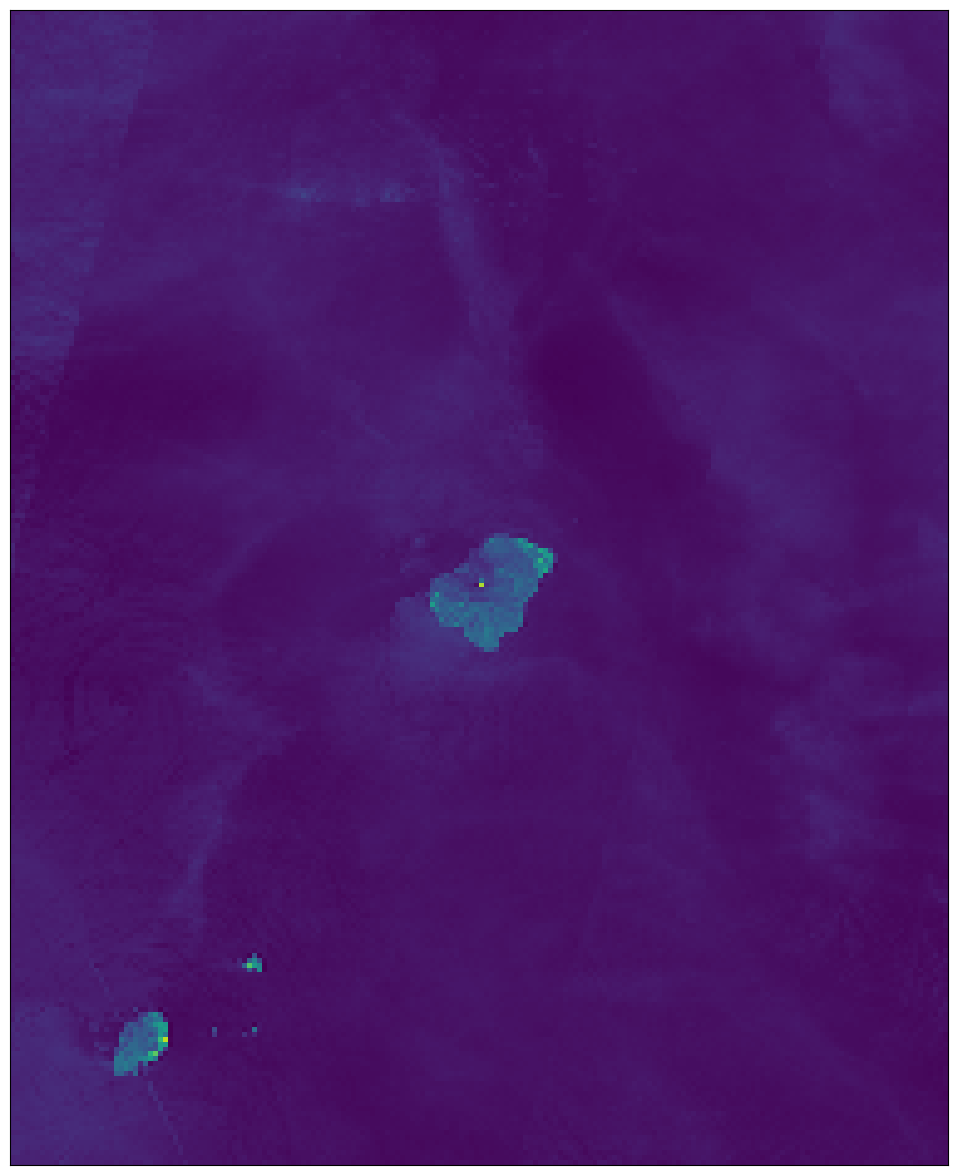

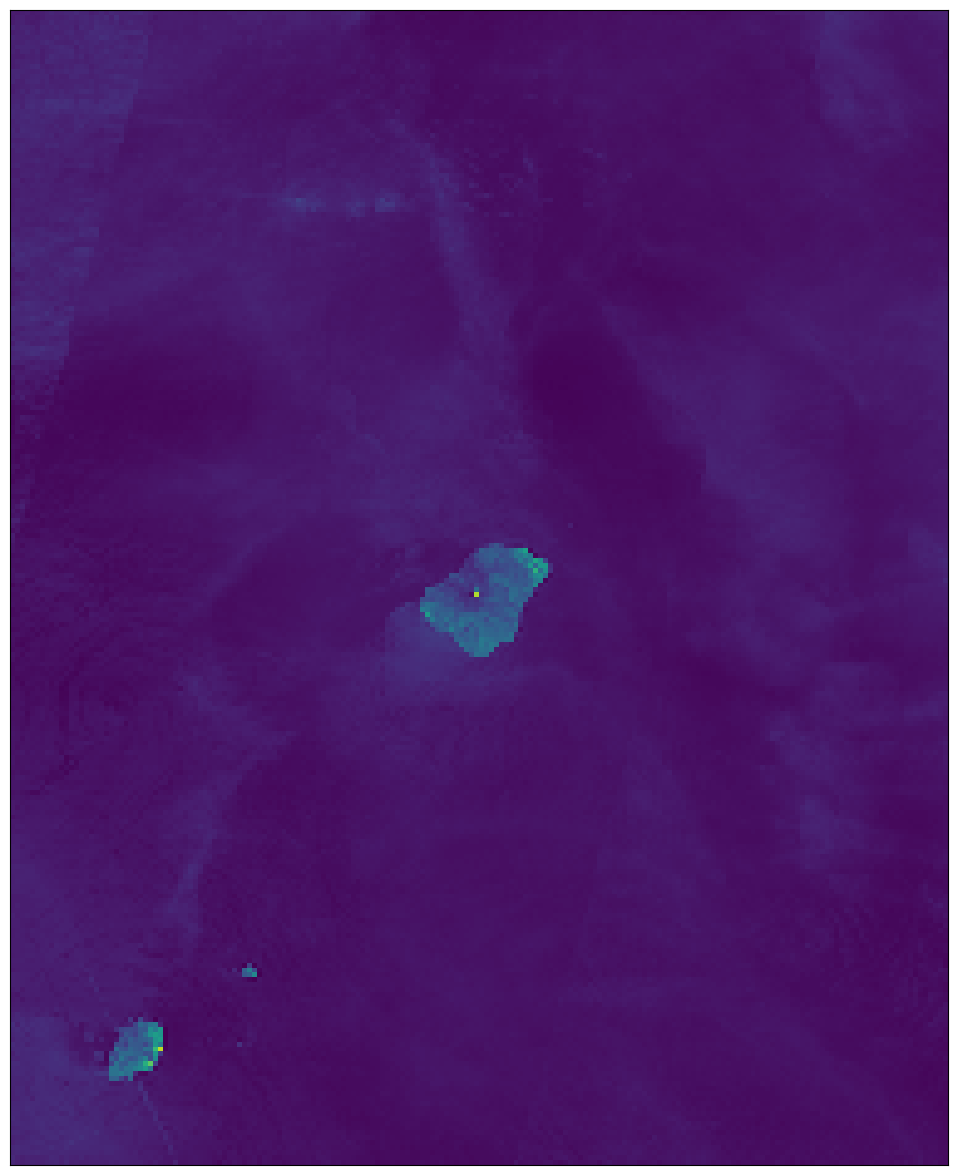

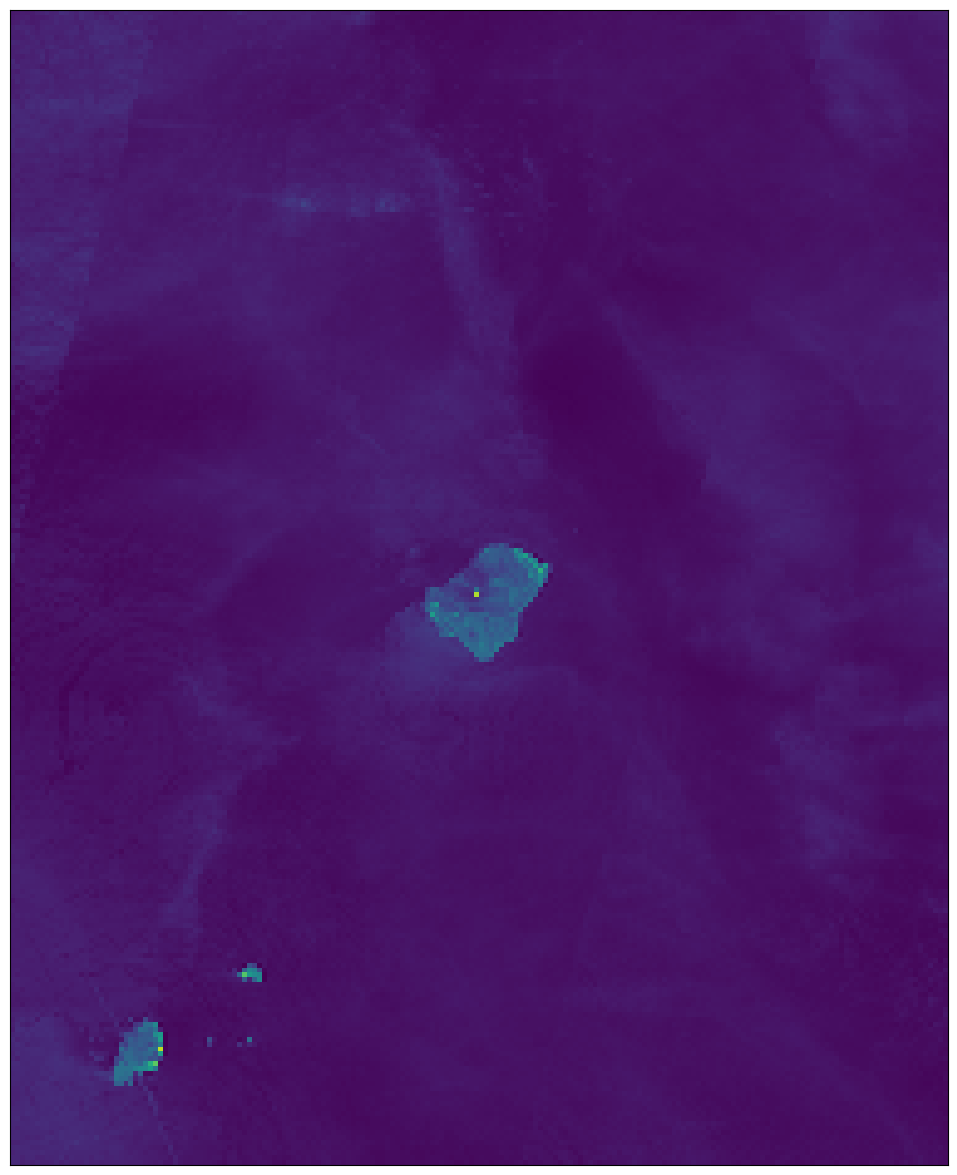

In [33]:

# Image.fromarray(get_sentinel_image([17.218, 40.499], "2024-05-07", config))
for index, row in fire_data.iterrows():
    day = row["acq_date"]
    day_date = datetime.strptime(day, "%Y-%m-%d")
    yesterday = (day_date - timedelta(days=1)).strftime("%Y-%m-%d")
    time_interval=(yesterday, day)
    image = get_sentinel_image([row["longitude"], row["latitude"]], time_interval, config)
    # image_data = get_sentinel_image_requests([row["longitude"], row["latitude"]], time_interval, access_token)
    # # Create a BytesIO object
    # image_io = io.BytesIO(image_data)
    # 
    # # Open the image from the bytes data
    # with rasterio.open(image_io) as src:
    #     # Read the first three bands into separate variables
    #     band1 = src.read(10)
    #     band2 = src.read(11)
    #     band3 = src.read(12)
    # 
    # # Stack bands
    # rgb = np.dstack((band1, band2, band3))
    # # if rgb is zero all over skip
    # if rgb.mean()==0:
    #     continue
    # rgb_norm = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb)) *255
    # # plot_image(rgb_norm.astype(np.uint8), factor=3.5 / 1e4, vmax=1)
    # # image = np.array(Image.open(io.BytesIO(image_data)))
    # plt.imshow(rgb_norm.astype(np.uint8))
    # plt.show()
    # # plot_image(image[:, :, 12], factor=3.5 / 1e4, vmax=1)
    # 
    print(image)
    # check if image is completly black display "picture not found" and location and date, else display image
    if image.mean() == 0:
        print(f"Picture not found for location {row['latitude']}, {row['longitude']} on {row['acq_date']}")
    else:
        pass
        plot_image(image[:, :, 12], factor=3.5 / 1e4, vmax=1)

In [37]:
# Define the coordinates of the point of interest
point_coords_wgs84 = [17.218, 40.499]
padding = 0.2
# Define a small bounding box around the point of interest
bbox_coords_wgs84 = [point_coords_wgs84[0] - padding, point_coords_wgs84[1] - padding, point_coords_wgs84[0] + padding, point_coords_wgs84[1] + padding]

# Create a BBox instance
bbox = BBox(bbox_coords_wgs84, crs=CRS.WGS84)

# Define the size of the image
x_size = 200
_, y_size = bbox_to_dimensions(bbox, resolution=x_size)  # Extract height from the tuple

# Define the request
request = SentinelHubRequest(
    evalscript="""
        //VERSION=3
        function setup() {
            return {
                input: ["B02", "B03", "B04"],
                output: { bands: 3 }
            };
        }
        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2024-04-07T00:00:00Z', '2024-05-07T23:59:59Z'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.JPG)
    ],
    bbox=bbox,
    size=(x_size, y_size),  # Pass height as a single integer
    config=config
)

# Download the image
image = request.get_data()[0]

# Display the image

Image.fromarray(image)

InvalidClientError: (invalid_client) Invalid client or Invalid client credentials